In [25]:
import os, sys
currentdir = os.path.dirname(os.path.realpath('testing_pipeline.ipynb'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

from importlib import reload  
import numpy as np
from skimage.io import imread, imshow
import random
import matplotlib.pyplot as plt
import cv2

from src import pipeline
pipeline = reload(pipeline)

NameError: name 'IMAGE_H' is not defined

In [19]:
# very complicated way to plot
# https://stackoverflow.com/questions/21754976/ipython-notebook-arrange-plots-horizontally
from IPython.display import HTML
import io
import base64

class FlowLayout(object):
    ''' A class / object to display plots in a horizontal / flow layout below a cell '''
    def __init__(self):
        # string buffer for the HTML: initially some CSS; images to be appended
        self.sHtml =  """
        <style>
        .floating-box {
        display: inline-block;
        margin: 10px;
        border: 3px solid #888888;  
        }
        </style>
        """

    def add_plot(self, oAxes):
        ''' Saves a PNG representation of a Matplotlib Axes object '''
        Bio=io.BytesIO() # bytes buffer for the plot
        fig = oAxes.get_figure()
        fig.canvas.print_png(Bio) # make a png of the plot in the buffer

        # encode the bytes as string using base 64 
        sB64Img = base64.b64encode(Bio.getvalue()).decode()
        self.sHtml+= (
            '<div class="floating-box">'+ 
            '<img src="data:image/png;base64,{}\n">'.format(sB64Img)+
            '</div>')

    def PassHtmlToCell(self):
        ''' Final step - display the accumulated HTML '''
        display(HTML(self.sHtml))


# Unet Mask

In [3]:
path = '../data/stacking/slice_test'
unet_model = '../data/weights/model_unet_checkpoint.h5'
yolo2_model = '../data/weights/yolo2_model.h5'
input_img = '../data/stacking/SCAN_2021-03-05_15-50-16/2021-03-05_15-50-16_0_0_5578.jpeg'
output_dir = '../data/stacking/slice_test'

In [4]:
pipeline.slice_img(input_img, output_dir, resize_factor = 0.2,
                  slice_height = 256, slice_width = 256,
                  zero_frac_tresh = 0.8, overlap = 0, pad = 0, verbose = True)

Directory  ../data/stacking/slice_test  already exists
dx 256
dy 256
image output: ../data/stacking/slice_test/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_0_256_256_0.png
image output: ../data/stacking/slice_test/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_256_256_256_0.png
image output: ../data/stacking/slice_test/slice_2021-03-05_15-50-16_0_0_5578.jpeg_0_400_256_256_0.png
image output: ../data/stacking/slice_test/slice_2021-03-05_15-50-16_0_0_5578.jpeg_237_0_256_256_0.png
image output: ../data/stacking/slice_test/slice_2021-03-05_15-50-16_0_0_5578.jpeg_237_256_256_256_0.png
image output: ../data/stacking/slice_test/slice_2021-03-05_15-50-16_0_0_5578.jpeg_237_400_256_256_0.png
Num slices: 6 Num non-null slices: 0 sliceHeight 256 sliceWidth 256


In [5]:
imgs, sizes_imgs  = pipeline.get_imgs(path)

In [6]:
pred_masks_t = pipeline.unet_predict(unet_model, imgs, sizes_imgs)

1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)



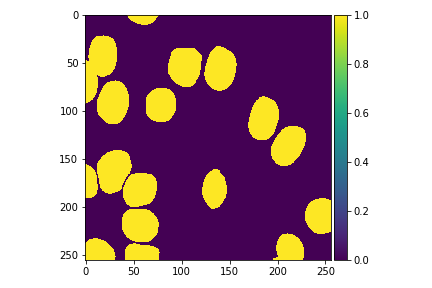
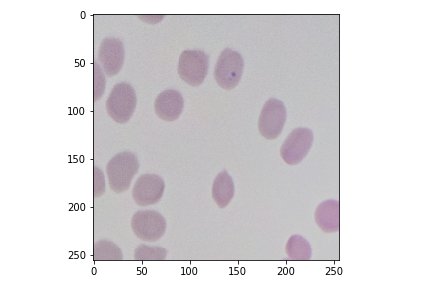
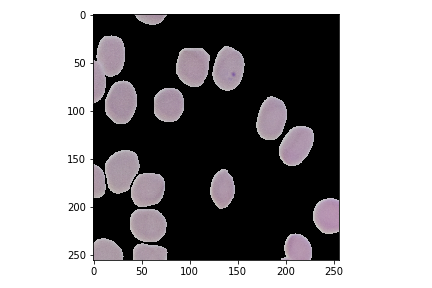

In [7]:
#pretty complicated just so we can plot next to each other
oPlot = FlowLayout() # create an empty FlowLayout

# Perform check on test set
ix = random.randint(0, len(pred_masks_t)-1)
oPlot.add_plot(imshow(np.squeeze(pred_masks_t[ix])))
plt.close() 
oPlot.add_plot(imshow(imgs[ix]))
plt.close() 
image_overlayed = np.where(np.squeeze(pred_masks_t[ix])[...,None], imgs[ix], 0)
oPlot.add_plot(imshow(image_overlayed)) # pass it to the FlowLayout to save as an image
plt.close() # this gets rid of the plot so it doesn't appear in the cell

oPlot.PassHtmlToCell()


In [8]:
num_labels, labels = cv2.connectedComponents(np.squeeze(pred_masks_t[ix]))

In [9]:
num_labels

18


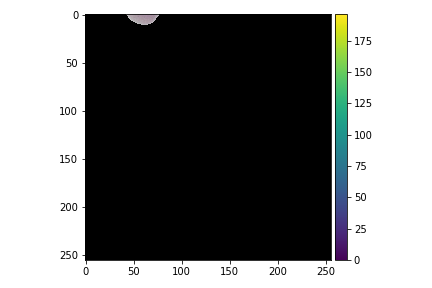
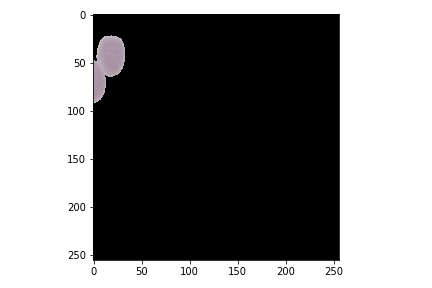
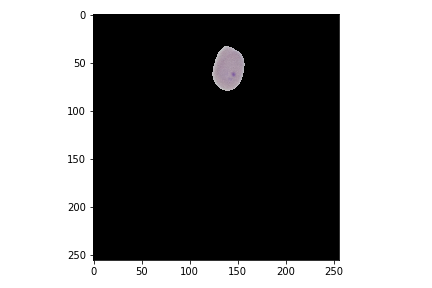
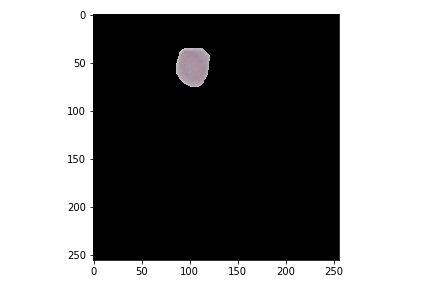
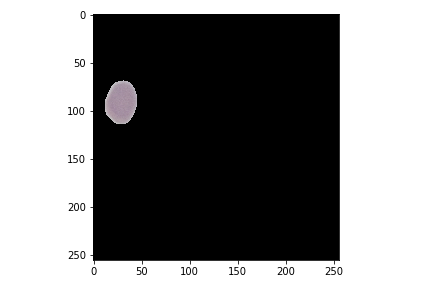
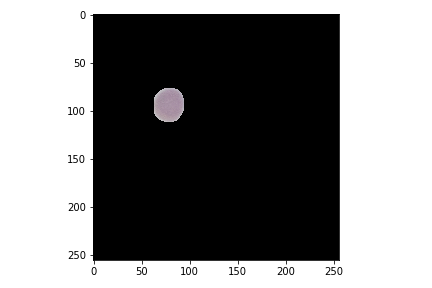
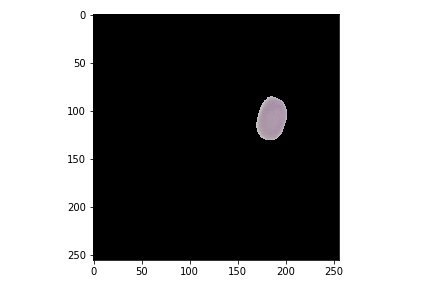
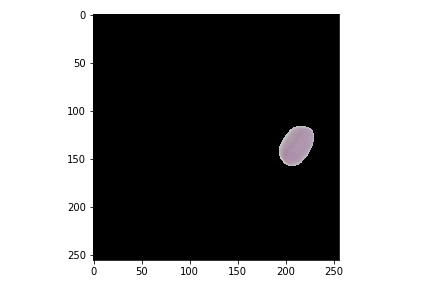
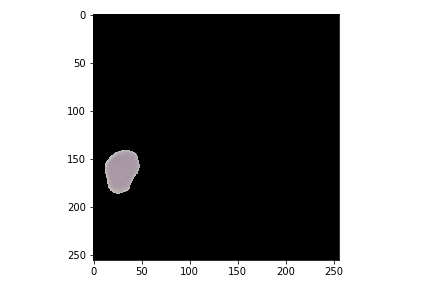
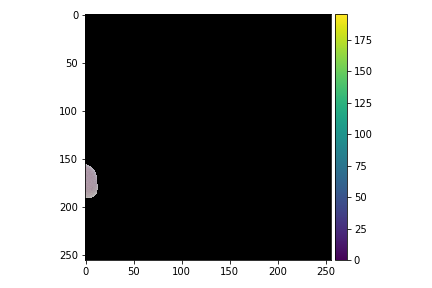
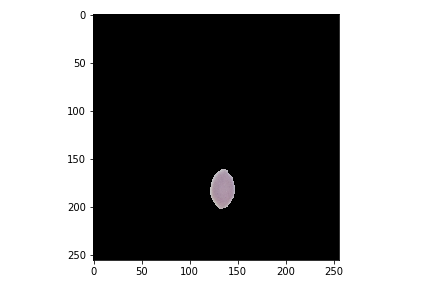
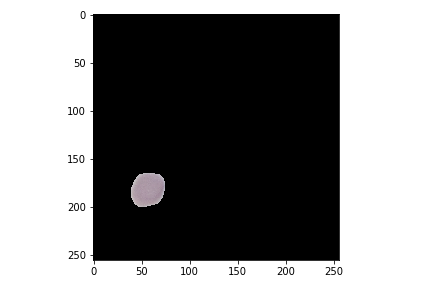
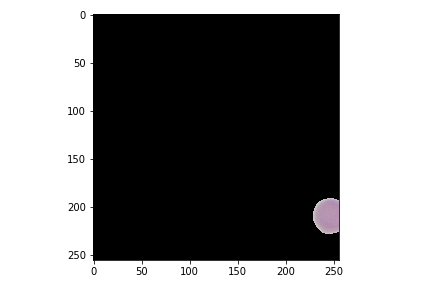
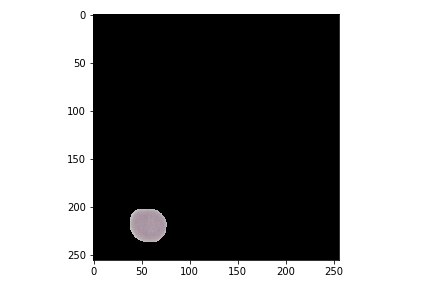
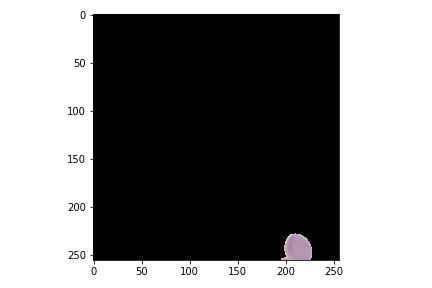
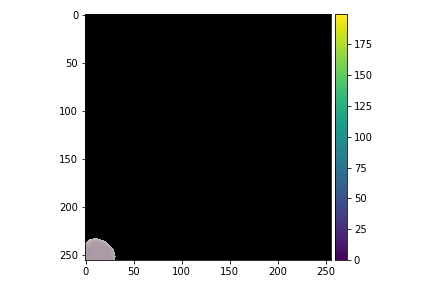
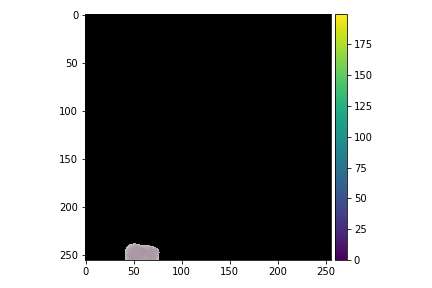

In [10]:
#pretty complicated just so we can plot next to each other
oPlot = FlowLayout() # create an empty FlowLayout

for label in range(1,num_labels):
    component = np.where(np.where(labels == label, 1, 0)[...,None], imgs[ix], 0)
    oPlot.add_plot(imshow(component)) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell

oPlot.PassHtmlToCell()

In [21]:
score_threshold  = 0.5
iou_threshold    = 0.45
for label in range(1,num_labels):
    component = np.where(np.where(labels == label, 1, 0)[...,None], imgs[ix], 0)
    pipeline.display_yolo(component, yolo2_model, score_threshold, iou_threshold, plot = True)

ValueError: Unknown layer: SpaceToDepth